In [ ]:
#Note! : cells to run enc/dec/classifier are updated to functionalized version
# visualizations are only partially updated to be compatible with functionalized versiON! 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
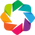

In [1]:
# import packages
import os 
path_main = '/home/anna/Src/spykshrk_realtime'
os.chdir(path_main)  # navigate to main spykshrk parent directory 

%load_ext autoreload
%autoreload 2
import holoviews as hv
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPEncoder, OfflinePPDecoder
from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer

hv.extension('bokeh')

In [3]:
#### Define parameters
rat_name = 'gus'
day =  18     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 4  # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/data2/mcoulter/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
day_ep = str(day) + '_' + str(epoch)

#tetrodes_dictionary = {'remy': [4,6,9,10,11,12,13,14,15,17,19,20,21,22,23,24,25,26,28,29,30], # for a 45 min runtime on virga use tetrodes 4,9,11,13,15,19,21,23,25,28,30
#                       'gus': [6,7,8,9,10,11,12,17,18,19,21,24,25,26,27,30], # list(range(6,13)) + list(range(17,22)) + list(range(24,28)) + [30]
#                        'bernard': [1,2,3,4,5,7,8,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], 
#                       'fievel': [1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,22,23,24,25,27,28,29]}

# if you want all ca1 tets with no deadchans, set tetlist to None. otherwise, specify list

tetlist = None
#tetlist = [4,6]

if tetlist is None:
    animalinfo  = {rat_name: Animal(directory=raw_directory, short_name=rat_name)}
    tetinfo = lfdp.tetrodes.make_tetrode_dataframe(animalinfo)
    tetinfo['ndtype'] = tetinfo['deadchans'].apply(lambda d: isinstance(d,np.ndarray)) # add column with datatype of deadchans entry
    tmp = tetinfo['deadchans'][tetinfo['ndtype'].values].apply(lambda d: len(d))   # add length of deadchans list
    tetinfo['ndlength'] = tmp   # store lengths as an additional column. no dead chans = length 0 
    tetrodes = tetinfo.query('area=="ca1" & ndlength==0 & day==@day & epoch==@epoch').index.get_level_values('tetrode_number').unique().tolist()   
else:
    tetrodes= tetlist
    
pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0

shift_amt_for_shuffle = 0

discrete_tm_val=.99   # for classifier

print(tetrodes)

[6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 24, 25, 26, 27, 30]


In [4]:
%%time
# IMPORT and process data

#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)
# Import marks
marks = datasrc.import_marks()
print('original length: '+str(marks.shape[0]))
# OPTIONAL: to reduce mark number, can filter by size. Current detection threshold is 100  
marks = trodes2SS.threshold_marks(marks, maxthresh=2000,minthresh=100)
# remove any big negative events (artifacts?)
marks = trodes2SS.threshold_marks_negative(marks, negthresh=-999)
print('after filtering: '+str(marks.shape[0]))

# Import trials
trials = datasrc.import_trials()

# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'

if os.path.exists(lin_output1) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')
    sungod_util.run_linearization_routine(rat_name, day, epoch, linearization_path, raw_directory, gap_size=20)
    linear_pos_raw['linpos_flat'] = np.load(lin_output1)
    track_segment_ids = np.load(lin_output2)
else: 
    print('Linearization found. Loading it')
    linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
    track_segment_ids = np.load(lin_output2)
    
# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))
# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# calculate bin coverage based on determined binned arm bounds   TO DO: prevent the annnoying "copy of a slice" error [prob need .values rather than a whole column]
pos_bin_delta = sungod_util.define_pos_bin_delta(binned_arm_coords, pos_bins, linear_pos_raw, pos_bin_size)

max_pos = binned_arm_coords[-1][-1]+1

Duplicate marks found (and removed): 0
original length: 2048354
29 above 2000uV events removed
0 below 100uV events removed
6 below -999uV events removed
after filtering: 2048319
Linearization result doesnt exist. Doing linearization calculation
Rips less than velocity thresh: 953
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 68

In [5]:
# decide what to use as encoding and decoding data
marks, binned_linear_pos = sungod_util.assign_enc_dec_set_by_velocity(binned_linear_pos, marks, velocity_thresh_for_enc_dec, velocity_buffer)

# rearrange data by trials 
pos_reordered, marks_reordered, order = sungod_util.reorder_data_by_random_trial_order(trials, binned_linear_pos, marks)

encoding_marks = marks_reordered.loc[marks_reordered['encoding_set']==1]
decoding_marks = marks_reordered.loc[marks_reordered['encoding_set']==0]
encoding_marks.drop(columns='encoding_set',inplace=True)  # drop these columns after use so they don't take up a bunch of extra space
decoding_marks.drop(columns='encoding_set',inplace=True)

print('Encoding spikes: '+str(len(encoding_marks)))
print('Decoding spikes: '+str(len(decoding_marks)))

encoding_pos = pos_reordered.loc[pos_reordered['encoding_set']==1]

# apply shift for shuffling 
encoding_marks_shifted, shift_amount = sungod_util.shift_enc_marks_for_shuffle(encoding_marks, shift_amt_for_shuffle)
# put marks back in chronological order for some reason
encoding_marks_shifted.sort_index(level='time',inplace=True)

Number of trials:  106
Encoding spikes: 866557
Decoding spikes: 1164570
Total epoch time (sec):  3726.3255333333327
9529.4272
0


In [6]:
# populate enc/dec settings. any parameter settable should be defined in parameter cell above and used here as a variable

encode_settings = trodes2SS.AttrDict({'sampling_rate': 3e4,
                                'pos_bins': np.arange(0,max_pos,1), # actually indices of valid bins. different from pos_bins above 
                                'pos_bin_edges': np.arange(0,max_pos + .1,1), # indices of valid bin edges
                                'pos_bin_delta': pos_bin_delta, 
                                # 'pos_kernel': sp.stats.norm.pdf(arm_coords_wewant, arm_coords_wewant[-1]/2, 1),
                                'pos_kernel': sp.stats.norm.pdf(np.arange(0,max_pos,1), max_pos/2, 1), #note that the pos_kernel mean should be half of the range of positions (ie 180/90)     
                                'pos_kernel_std': 0, # 0 for histogram encoding model, 1+ for smoothing
                                'mark_kernel_std': int(20), 
                                'pos_num_bins': max_pos, 
                                'pos_col_names': [pos_col_format(ii, max_pos) for ii in range(max_pos)], # or range(0,max_pos,10)
                                'arm_coordinates': binned_arm_coords,   
                                'spk_amp': 60,
                                'vel': 0}) 

decode_settings = trodes2SS.AttrDict({'trans_smooth_std': 2,
                                'trans_uniform_gain': 0.0001,
                                'time_bin_size':60})

sungod_trans_mat = sungod_util.calc_sungod_trans_mat(encode_settings, decode_settings)

In [7]:
%%time
# run encoder
print('Starting encoder')

encoder = OfflinePPEncoder(linflat=encoding_pos, dec_spk_amp=decoding_marks, encode_settings=encode_settings, 
                               decode_settings=decode_settings, enc_spk_amp=encoding_marks_shifted, dask_worker_memory=1e9,
                               dask_chunksize = None)

    #new output format from encoder: observ_obj
observ_obj = encoder.run_encoder()


22:54:51 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Dask chunksize: 72
22:54:51 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Memory utilization at: 50.0%
22:54:51 [INFO] spykshrk.franklab.pp_decoder.pp_clusterless: Expected worker peak memory usage: 476.01 MB


Starting encoder
CPU times: user 7h 23min 35s, sys: 15h 18min 17s, total: 22h 41min 53s
Wall time: 30min 46s


In [8]:
%%time

print('Starting decoder')

decoder = OfflinePPDecoder(observ_obj=observ_obj, trans_mat=sungod_trans_mat, 
                               prob_no_spike=encoder.prob_no_spike,
                               encode_settings=encode_settings, decode_settings=decode_settings, 
                               time_bin_size=decode_settings.time_bin_size, all_linear_position=binned_linear_pos)

posteriors = decoder.run_decoder()
print('Decoder finished!')
print('Posteriors shape: '+ str(posteriors.shape))

Starting decoder
Beginning likelihood calculation
Beginning posterior calculation
Decoder finished!
Posteriors shape: (1863242, 148)
CPU times: user 21min 9s, sys: 21min 9s, total: 42min 19s
Wall time: 12min 55s


In [ ]:
%%time
# run classifier 
sungod_no_offset = sungod_util.calc_sungod_trans_mat(encode_settings, decode_settings, uniform_gain=0)

causal_state1, causal_state2, causal_state3, acausal_state1, acausal_state2, acausal_state3, trans_mat_dict = sungod_util.decode_with_classifier(decoder.likelihoods, 
                                                                                                                                 sungod_no_offset, 
                                                                                                                                 encoder.occupancy, discrete_tm_val)

## SAVE STUFF IF YOU WANT

In [9]:
# TEMPORARY: save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day) + '_' + str(epoch) + '_shuffle_' + str(shift_amount) + '_posteriors_functionalized.nc'

post1 = posteriors.apply_time_event(rips, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = trodes2SS.convert_dan_posterior_to_xarray(post2, tetrodes, 
                                        velocity_thresh_for_enc_dec, encode_settings, decode_settings, sungod_trans_mat, order, shift_amount)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day) + '_' + str(epoch) + '_shuffle_' + str(shift_amount) + '_linearposition_functionalized.nc'

linearized_pos1 = binned_linear_pos.apply_time_event(rips, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)

Saved posteriors to /data2/mcoulter/remy/gus_18_4_shuffle_0_posteriors_functionalized.nc
Saved linearized position to /data2/mcoulter/remy/gus_18_4_shuffle_0_linearposition_functionalized.nc


In [11]:
# save classifier outputs 
base_name = '/data2/mcoulter/remy/' + rat_name + '_' + day_ep + '_shuffle_' + str(shift_amount) + '_posterior_'
fname = 'causal'
trodes2SS.convert_save_classifier(base_name, fname, causal_state1, causal_state2, causal_state3, tetrodes, decoder.likelihoods,
                                  encode_settings, decode_settings, rips, velocity_thresh_for_enc_dec, velocity_buffer, sungod_no_offset, order, shift_amount)

fname = 'acausal'
trodes2SS.convert_save_classifier(base_name, fname, acausal_state1, acausal_state2, acausal_state3, tetrodes, decoder.likelihoods,
                                  encode_settings, decode_settings, rips, velocity_thresh_for_enc_dec, velocity_buffer, sungod_no_offset, order, shift_amount)

## VISUALIZE STUFF 

In [ ]:
# plot the various transition matrices if you want
hv.Layout(hv.Image(trans_mat_dict['continuous'])+hv.Image(trans_mat_dict['identity'])+hv.Image(trans_mat_dict['uniform']))

In [ ]:
%%opts Overlay [height=300, width=900] 

h1 = hv.Curve(np.sum(causal_posterior[:,0,:,0],axis=1))
h2 = hv.Curve(np.sum(causal_posterior[:,1,:,0],axis=1))
h3 = hv.Curve(np.sum(causal_posterior[:,2,:,0],axis=1))
hv.Overlay([h1,h2,h3])

In [298]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

# visualize posteriors - note will only work a small chunck of the posteriors table

dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], riptimes=rips_vel_filtered[0:100], enc_settings=encode_settings)

#dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)

/home/mcoulter/anaconda3/lib/python3.6/site-packages/holoviews/core/data/pandas.py:130: FutureWarning:
from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


:DynamicMap   [time]
   :Overlay
      .RGB.I           :RGB   [time (s),linpos (cm)]   (R,G,B,A)
      .Points.Linpos   :Points   [time (s),linpos (cm)]
      .Arm_bound.I     :Curve   [x]   (y)
      .Arm_bound.II    :Curve   [x]   (y)
      .Arm_bound.III   :Curve   [x]   (y)
      .Arm_bound.IV    :Curve   [x]   (y)
      .Arm_bound.V     :Curve   [x]   (y)
      .Arm_bound.VI    :Curve   [x]   (y)
      .Arm_bound.VII   :Curve   [x]   (y)
      .Arm_bound.VIII  :Curve   [x]   (y)
      .Arm_bound.IX    :Curve   [x]   (y)
      .Arm_bound.X     :Curve   [x]   (y)
      .Arm_bound.XI    :Curve   [x]   (y)
      .Arm_bound.XII   :Curve   [x]   (y)
      .Arm_bound.XIII  :Curve   [x]   (y)
      .Arm_bound.XIV   :Curve   [x]   (y)
      .Arm_bound.XV    :Curve   [x]   (y)
      .Arm_bound.XVI   :Curve   [x]   (y)
      .Arm_bound.XVII  :Curve   [x]   (y)
      .Arm_bound.XVIII :Curve   [x]   (y)
      .Events.Ripples  :Polygons   [x,y]

In [ ]:
# OPTIONAL: save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_shuffle_' + str(marks_index_shift) + '_posteriors_posbin3.nc'

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2, tetrodes_dictionary[rat_name], 
                                        velocity_filter, encode_settings, decode_settings, encoder.trans_mat['sungod'], trialsindex_shuffled, marks_index_shift)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_shuffle_' + str(marks_index_shift) + '_linearposition_posbin3.nc'

linearized_pos1 = pos_all_linear.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)
    

In [ ]:
%%output size=100 backend='bokeh'
%%opts Curve [aspect=4] (color='black') 

# plot binning of data into 5cm bins -- (before randomization of trial order!)

p1 = hv.Curve(pos_all_linear['linpos_flat'],'time','linpos (cm)',group='orig')
p2 = hv.Curve(5*digitized,'time','binindex',group='digitized (x5 for scale)')
layout = hv.Layout(p1 +p2).cols(2)
layout

In [ ]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}

# plot postition histogram, marks histogrm, and firing rate (+ FR normalization stages)

poshist, posbins = np.histogram(a=random_trial_pos_all_vel['linpos_flat'], bins=np.arange(0,147),normed=False)
hist1 = hv.Histogram(poshist,group='encode pos')
linflat_obj = random_trial_pos_all_vel.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(encode_spikes_random_trial_chron)
marks_linear = encode_spikes_random_trial_chron.assign(linear_pos=pd.Series(linflat_spkindex['linpos_flat']).values)
markshist, marksbins = np.histogram(a=marks_linear['linear_pos'], bins=np.arange(0, 147),normed=False)
hist2 = hv.Histogram(markshist,group='encode mark pos')
hist3 =hv.Histogram(encoder.occupancy,group='occupancy')
hist4 = hv.Histogram(encoder.firing_rate[4],group='encoder FR')
hist5 = hv.Histogram(encoder.firing_rate[4]/encoder.occupancy,group='occ norm FR')
hist6 = hv.Histogram(encoder.prob_no_spike[4],extents=(0, .98, 147, 1),group='pns')
layout = hv.Layout(hist1 + hist2+hist3+hist4+hist5+hist6).cols(3)    #
layout

In [ ]:
%%output backend='bokeh' size=100
%%opts Histogram {+axiswise}

# histograms of peak probability for observations, likelihoods, and posteriors 

hist_obs = []
obs_binsonly = observ_obj.drop(['elec_grp_id','position','dec_bin','dec_bin_start','num_missing_bins','parallel_bin'], axis=1)
#take axis label of max obs density, remove x prefix and cast as int to get binind
obs_maxbin = obs_binsonly.idxmax(axis=1).str.strip('x').astype(int) 
obshist,tmp = np.histogram(obs_maxbin,bins=np.arange(0,147))
h1 = hv.Histogram(obshist,group='max ind of observations')

lik_binsonly = decoder.likelihoods.drop(['num_spikes','dec_bin'], axis=1)
lik_maxbin = lik_binsonly.fillna(0).idxmax(axis=1).str.strip('x').astype(int)
lik_hist,tmp = np.histogram(lik_maxbin,bins=np.arange(0,147))
h2 = hv.Histogram(lik_hist,group='max ind of likelihoods')

post_binsonly = posteriors.drop(['num_spikes','dec_bin'], axis=1)
post_maxbin = post_binsonly.fillna(0).idxmax(axis=1).str.strip('x').astype(int)
post_hist,tmp = np.histogram(post_maxbin,bins=np.arange(0,147))
h3 = hv.Histogram(post_hist,group='max ind of posteriors')
layout = hv.Layout(h1+h2+h3)
layout

## STEP BY STEP ENCODING/DECODING

In [ ]:
%%output size=100 backend='bokeh'
%%opts Histogram {+axiswise}
%%opts Scatter {+axiswise}
%%opts Image (cmap='viridis') {+axiswise}

# STEP BY STEP ENC/DEC : get observations 
#  TO DO: add something here to visualize the mark smoothing 

# 1. get the positions corresponding to each spike time of the encoding spikes
#    smooth them with a gaussian (pos_kernel_std). plot this as histogram

tetnum = 4
singletetenc_marks = encoding_marks_shifted.loc[encoding_marks_shifted.index.get_level_values('elec_grp_id')==tetnum]
singletetenc_pos = encoding_pos.get_irregular_resampled(singletetenc_marks)
pos_distrib_tet = sp.stats.norm.pdf(np.expand_dims(encode_settings.pos_bins,0),np.expand_dims(singletetenc_pos['linpos_flat'],1),1)

p1 = hv.Image(np.flipud(pos_distrib_tet[1:5000:1,:].T), kdims=['spike event','pos_bins'],bounds = (0,0,5000, pos_distrib_tet.shape[1]),group='encoding model smoothed position')
spikinghist,_ = np.histogram(singletetenc_pos['linpos_flat'][:5000],bins = np.arange(0,147))
p2 = hv.Histogram(spikinghist ,group='enc poshist (occupancy;first5000)')

# 2. get the mark contrib weights, based on the distance between each decoding and encoding spike
    # combine across mark dimensions
singletetdec_marks = decode_spikes_random_trial.loc[decode_spikes_random_trial.index.get_level_values('elec_grp_id')==tetnum]
mark_contrib = normal_pdf_int_lookup(np.expand_dims(singletetdec_marks[4000:10000], 1),
                                             np.expand_dims(singletetenc_marks, 0),
                                             encode_settings.mark_kernel_std)
all_contrib = np.prod(mark_contrib, axis=2)

# 3. multiply encoding spikes by their weights to generate observations; plot
observ = np.matmul(all_contrib, pos_distrib_tet) # can handle all! [5000:15000]
p4 = hv.Image(np.flipud(observ.T), kdims=['decoding spk','pos_bins'],bounds = (0,0,4000, pos_distrib_tet.shape[1]),group='obs no norm')

# 4. normalize obs by occupancy, POS_DELTA, and within each row
newspikinghist = np.array(spikinghist).astype(float)  #make occupancy contain nans not zeros, like real one
newspikinghist[newspikinghist==0]=np.nan
normed_observ = observ / (encoder.occupancy*pos_delta)
observ_sum = np.nansum(normed_observ, axis=1)

if any(observ_sum==0): # replace all rows that are all zeros with uniform distribution 
    print('found a zero-row!?') # still don't quite understand when this occurs, but it happens 
    observ_sum_zero = observ_sum == 0
    observ[observ_sum_zero, :] = 1/(encode_settings.pos_bins[-1] - encode_settings.pos_bins[0])
    observ_sum[observ_sum_zero] = 1

newnormed_observ = normed_observ / observ_sum[:, np.newaxis]
p5 = hv.Image(np.flipud(newnormed_observ.T), kdims=['decoding spk','pos_bins'],bounds = (0,0,4000, pos_distrib_tet.shape[1]),group='obs normed')

# 5. sanity check: histogram of actual decoding spike locations
singletetdec_pos = random_trial_pos_all_vel.get_irregular_resampled(singletetdec_marks)
decspikinghist,_ = np.histogram(singletetdec_pos['linpos_flat'][:4000],bins = np.arange(0,147))
p6 = hv.Histogram(decspikinghist ,group='to check: dec occupancy first5000)')

layout = hv.Layout(p1+p2+p4+p5).cols(2)
layout


In [ ]:
%%output backend='bokeh' size=100
%%opts Scatter {+axiswise}
%%opts Curve {+axiswise}

# plot the mark weights assigned to encoding spikes (or first 500o at least) for each decoding spike one by one

def plot_observ(ind):
    markweights = np.vstack((singletetenc_pos[:5000]['linpos_flat'],all_contrib[ind,:5000]))
    p3 = hv.Scatter(markweights.T,extents=(0, 0, 145, 2e-7), group='enc spike weights for 1 decspk')
    p4 = hv.Curve(newnormed_observ[ind,:],extents=(0, 0, 145, .2),group='normalized observation')
    return hv.Layout(p3+p4)
        
dmap = hv.DynamicMap(plot_observ, kdims=['ind'])
dmap.redim.values(ind=list(range(0, 50, 1)))

## OBS -> POSTERIORS

In [ ]:
%%output backend='bokeh'
%%opts Histogram [height=300, width=400] {+axiswise} 

# plot how many spikes are in all the bins

bincounts,binedges=np.histogram(observ_obj['dec_bin'],bins=np.arange(0,observ_obj['dec_bin'].max()),normed=False)
binsummary =  np.histogram(bincounts,bins=np.arange(0,12,1),normed=False)
h1 = hv.Histogram(binsummary, group='num spikes per bin (decoding)')
h1

In [ ]:
%%output backend='bokeh' size=100
%%opts Curve [height=300, width=400] {+axiswise}

# plot the OBS -> LIKELIHOODS transformation for one decoding bin at a time

g_prob_no_spike = np.prod(list(encoder.prob_no_spike.values()), axis=0)
g_prob_no_spike = g_prob_no_spike/np.nansum(g_prob_no_spike)  # normalize

newobs = observ_obj.set_index('dec_bin')

def plot_observ(dec_bin_val):
    #liklihoods get calculated regardless of spk input
    dec_bin_lik = decoder.likelihoods[decoder.likelihoods['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    h4 = hv.Curve(dec_bin_lik.values[0],extents=(0, 0, 147, 1),group='likelihood')
    # posteriors
    dec_bin_post = posteriors[posteriors['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    h5 = hv.Curve(dec_bin_post.values[0],extents=(0, 0, 147, .5),group='posterior')
    obs_empty = hv.Curve(np.zeros(142),extents=(0, 0, 147, .2),group='normalized observation')  # zero line placeholder 
    pns_empty = hv.Curve(np.zeros(142),extents=(0, .95, 147, 1),group='prob no spike')  # zero line placeholder 
    plot_list1 = [obs_empty,obs_empty,obs_empty,obs_empty,obs_empty]
    plot_list2 = [pns_empty,pns_empty,pns_empty,pns_empty,pns_empty]
    if dec_bin_val in newobs.index.values:
        dec_grp = newobs.loc[dec_bin_val]
        spikers = dec_grp['elec_grp_id'].tolist()
        if isinstance(spikers,float):
            dec_grp_pos = dec_grp.drop(['elec_grp_id','position','dec_bin_start','num_missing_bins','parallel_bin'], axis=0)
            plot_list1[0] = hv.Curve(dec_grp_pos,extents=(0, 0, 145, .2),group='normalized observation')
            plot_list2[0] = hv.Curve(encoder.prob_no_spike[spikers],extents=(0, .95, 145, 1),group='prob no spike')
        else:
            dec_grp_pos = dec_grp.drop(['elec_grp_id','position','dec_bin_start','num_missing_bins','parallel_bin'], axis=1)
            
            for idx in range(0,len(spikers)):
                plot_list1[idx] = hv.Curve(dec_grp_pos.iloc[idx,:],extents=(0, 0, 145, .2),group='normalized observation')
                plot_list2[idx] = hv.Curve(encoder.prob_no_spike[spikers[idx]],extents=(0, .95, 145, 1),group='prob no spike')
        plot_list1[4] = hv.Text(70,.15,'tets: ' +str(spikers))
        both = hv.Layout(hv.Overlay(plot_list1)+hv.Overlay(plot_list2)+h4+h5).cols(2)
        return both
    else:
        plot_list2[0] = hv.Curve(g_prob_no_spike,extents=(0, .95, 145, 1),group='prob no spike')
        both = hv.Layout(hv.Overlay(plot_list1)+hv.Overlay(plot_list2)+h4+h5).cols(2)
        return both
    
dmap = hv.DynamicMap(plot_observ, kdims=['dec_bin_val'])
dmap.redim.values(dec_bin_val=list(range(0, 50, 1))) #

In [ ]:
%%output backend='bokeh' size=100
%%opts Curve [height=300, width=200] 
#%%opts Image [height=300, width=250]  {+axiswise}

# plot the LIKLIEHOODS -> POSTERIORS transofrmation  across one decoding bin at a time 

def plot_observ(dec_bin_val):
    # trans mat
    h6 = hv.Image(np.flipud(transition_mat),bounds = (0,0,142,142),group = 'trans mat')
    #last post x trans mat
    prev_post = posteriors[posteriors['dec_bin'].values==(dec_bin_val-1)].drop(['num_spikes','dec_bin'],axis=1)
    prev_post_stack = np.vstack((prev_post.values,np.arange(0,147)))
    h5 = hv.Curve(prev_post_stack.T,extents=(0, 0,.1,145),group='prev post')
    # multiply together, plot result
    prevxTM = np.matmul(transition_mat, prev_post.values[0])
    prevxTMstack = np.vstack((prevxTM,np.arange(0,142)))
    h7 = hv.Curve(prevxTMstack.T,group='pXtm')
    # plot current likelihood, multiply by newloc
    curr_lik = decoder.likelihoods[decoder.likelihoods['dec_bin'].values==dec_bin_val].drop(['num_spikes','dec_bin'],axis=1)
    curr_lik_stack = np.vstack((curr_lik.values,np.arange(0,142)))
    h4 = hv.Curve(curr_lik_stack.T,group='likelihood')
    curr_post = posteriors[posteriors['dec_bin'].values==(dec_bin_val)].drop(['num_spikes','dec_bin'],axis=1)
    curr_post_stack = np.vstack((curr_post.values,np.arange(0,142)))
    h8 = hv.Curve(curr_post_stack.T,group='post')
    both = hv.Layout(h5+h7+h4+h8).cols(5)
    return both
    
dmap = hv.DynamicMap(plot_observ, kdims=['dec_bin_val'])
dmap.redim.values(dec_bin_val=list(range(1, 50, 1))) #  can't start with zero (so can get last post)

In [ ]:
#hv.Image(encoder.trans_mat['flat_powered'],group = 'trans mat')
hv.Image(transition_mat)

# the guts of calc_obs_single_bin   - for running line by line

In [ ]:
test_obs = observ_obj[:20]
elec_grp_list = test_obs['elec_grp_id'].unique()
global_prob_no_spike = np.prod(list(encoder.prob_no_spike.values()), axis=0)
global_prob_no_spike = global_prob_no_spike/sum(global_prob_no_spike)
results = []
dec_grp = Groupby(test_obs.values,test_obs['dec_bin'].values)  #ind=dec_bin, spks = list of obs from each spk 
pos_col_ind = test_obs.columns.slice_locs(encode_settings.pos_col_names[0],encode_settings.pos_col_names[-1])
elec_grp_ind = test_obs.columns.get_loc('elec_grp_id')
num_missing_ind = test_obs.columns.get_loc('num_missing_bins')
dec_bin_start_ind = test_obs.columns.get_loc('dec_bin_start')
for dec_bin_i, spks in dec_grp:
    #print('dec_bin_ind '+str(dec_bin_i))
    obv_in_bin = np.ones(142)
    num_spikes = len(spks)
    elec_set = set()
    spike_bin_raw = spks
    missing_bins_list=[]
    dec_bin_timestamp = spike_bin_raw[0,dec_bin_start_ind] #pull out record of bin start ind
    plotlist=[]
    
    for obv, elec_grp_id, num_missing_bins in zip(spike_bin_raw[:, slice(*pos_col_ind)],spike_bin_raw[:, elec_grp_ind], spike_bin_raw[:, num_missing_ind]):
        elec_set.add(elec_grp_id)
        missing_bins_list.append(num_missing_bins)
        #multiply each obv x that tet's PNS, renormalize
        obv_in_bin = obv_in_bin * obv
        obv_in_bin = obv_in_bin * encoder.prob_no_spike[elec_grp_id]
        obv_in_bin = obv_in_bin / (np.nansum(obv_in_bin) * encode_settings.pos_bin_delta)
        
    # Contribution for electrodes that no spikes in this bin
    for elec_grp_id in elec_set.symmetric_difference(elec_grp_list):
        obv_in_bin = obv_in_bin * encoder.prob_no_spike[elec_grp_id]
        obv_in_bin = obv_in_bin / (np.nansum(obv_in_bin) * encode_settings.pos_bin_delta)
    # only the final entry of missing bins list can be a number (meaning that there are n missing bins following)    
    missing_bins_list = np.array(missing_bins_list)
    if np.count_nonzero(missing_bins_list) > 1:
        warnings.warn('For decode bin (' + dec_bin_ii + ') bin time (' + dec_bin_timestamp +
                              ') there are multiple possible values for missing bins ' + missing_bins_list +
                              ', which is not allowed.')
    # append the results for this bin to the running list 
    results.append(np.concatenate([obv_in_bin, [dec_bin_timestamp, num_spikes, dec_bin_i]]))
    # if there are missing bins, append a row (containing g_PNS) for each empty bin
    for missing_ii in range(int(max(missing_bins_list))):
        #print('missing '+str(missing_ii))
        #print([dec_bin_timestamp+((missing_ii+1)*time_bin_size), 0, dec_bin_i+missing_ii+1])
        results.append(np.concatenate([global_prob_no_spike, [dec_bin_timestamp+((missing_ii+1)*time_bin_size),
                                                                      0, dec_bin_i+missing_ii+1]]))
# convert results into dataframe format
test_lik = pd.DataFrame(np.vstack(results),columns=encode_settings.pos_col_names+['timestamp', 'num_spikes', 'dec_bin'])

In [ ]:
# check the value of numpy epsilon for this machine
np.finfo(np.float32).eps

# STUFF FROM MIKE

In [ ]:
# save posteriors and position
posterior_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_posteriors_6_4_19.nc'

post1 = posteriors.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
post2 = post1.reset_index()
post3 = convert_dan_posterior_to_xarray(post2, tetrodes_dictionary[rat_name], velocity_filter, encode_settings, decode_settings, encoder.trans_mat['flat_powered'], offset_30Hz_time_bins, trialsindex_shuffled, marks_index_shift)
    #print(len(post3))
post3.to_netcdf(posterior_file_name)
print('Saved posteriors to '+posterior_file_name)

    # to export linearized position to MatLab: again convert to xarray and then save as netcdf

position_file_name = '/data2/mcoulter/remy/' + rat_name + '_' + str(day_dictionary[rat_name][0]) + '_' + str(epoch_dictionary[rat_name][0]) + '_vel4_position_bins_mask_convol_new_pos_yes_random_marks_shuffle_' + str(marks_index_shift) + '_linearposition_6_4_19.nc'

linearized_pos1 = pos_all_linear.apply_time_event(rips_vel_filtered, event_mask_name='ripple_grp')
linearized_pos2 = linearized_pos1.reset_index()
linearized_pos3 = linearized_pos2.to_xarray()
linearized_pos3.to_netcdf(position_file_name)
print('Saved linearized position to '+position_file_name)
    

In [ ]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Points [height=100 width=250 aspect=2 ] (marker='o' color='#AAAAFF' size=1 alpha=0.7)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.5)
#%%opts Image {+framewise}

# visualize posteriors - note will only work a small chunck of the posteriors table

dec_viz = DecodeVisualizer(posteriors[0:200000], linpos=pos_all_linear.loc[(pos_all_linear["linvel_flat"]>4)], riptimes=rips_vel_filtered[50:100], enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=100, slide=10)


In [ ]:
test = random_trial_pos_all.get_irregular_resampled(random_trial_spk_subset_sparse).reset_index()
above = test['linvel_flat']>4    # generate boolean of above/below velocity threshold
abovediff = np.insert(np.diff(above.astype(int)),0,0)   # convert boolean to int, calc diff, add a leading 0 to restore array length
notstops = np.where(abovediff!=-1)  # find 
stoptimes = pd.DataFrame({'col':test['time']})
stoptimes['col'].iloc[notstops]=np.nan
stoptimes = stoptimes.ffill().fillna()
inWindow = (test['time']-stoptimes['col'])<=2


In [ ]:
#test['linvel_flat'].iloc[above|inWindow]
both = above | inWindow
test['time'].loc[both]

In [ ]:
above = test['linvel_flat']>4
abovediff = np.diff(above.astype(int))
stops = np.where(abovediff==-1)
stoptimes = test.get_level_values['t']

In [ ]:
#hv.Layout(hv.Curve((test['time'],test['linvel_flat']) + hv.Scatter((stoptimes,4*np.ones(len(stoptimes))))))
hv.Overlay([hv.Curve((test['time'],test['linvel_flat'])),
            hv.Points((stoptimes['col'],4*np.ones(len(stoptimes['col'])))),
            hv.Curve((test['time'],inWindow.astype(int))),
            hv.Curve((test['time'].loc[above|inWindow],test['linvel_flat'].loc[above|inWindow]))])

In [ ]:
velocity_filter = 4
print('Velocity filter: ',velocity_filter)

    # #encoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_encode_velthresh = linflat_spkindex.query('linvel_flat > @velocity_filter')
encode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_encode_velthresh.index]

    # re-order encoding spikes after get_irregular_resample to match random trial order with position


encode_spikes_random_trial_random = encode_spikes_random_trial.head(0)
for i in range(len(starttimes_shuffled)):
    encode_random_spikes = encode_spikes_random_trial.loc[(encode_spikes_random_trial.index.get_level_values('time') <= endtimes_shuffled[i]) & (encode_spikes_random_trial.index.get_level_values('time') >= starttimes_shuffled[i])]
    encode_spikes_random_trial_random = encode_spikes_random_trial_random.append(encode_random_spikes)

print('encoding spikes after velocity filter: '+str(encode_spikes_random_trial.shape[0]))

    # #decoding spikes
linflat_obj = random_trial_pos_all.get_mapped_single_axis()
linflat_spkindex = linflat_obj.get_irregular_resampled(random_trial_spk_subset_sparse)
linflat_spkindex_decode_velthresh = linflat_spkindex.query('linvel_flat < @velocity_filter')

decode_spikes_random_trial = random_trial_spk_subset_sparse.loc[linflat_spkindex_decode_velthresh.index]

print('decoding spikes after velocity filter: '+str(decode_spikes_random_trial.shape[0]))

    #filter position for velocity
random_trial_pos_all_vel = random_trial_pos_all.loc[(random_trial_pos_all['linvel_flat']>velocity_filter)]
    #random_trial_pos_all_vel = pos_all_linear.loc[(pos_all_linear['linvel_flat']>velocity_filter)]

In [ ]:
test = pd.DataFrame({'col':[np.nan, np.nan, np.nan, 1, None, None, None, 4]})
test.bfill(axis='rows')


In [ ]:
test = pd.DataFrame([1,2,3,4,5,6,7,8,9,0])
test2 = pd.DataFrame([1,2,3,4,5])

t1 = test2>3
t1